# Installation

In [ ]:
#!pip install deap
#!pip install cdt

In [ ]:
from cdt.data import AcyclicGraphGenerator
generator = AcyclicGraphGenerator('linear', npoints=1000, nodes=30)
data, graph = generator.generate()

In [ ]:
print(data.shape)

In [ ]:
print(type(graph))

# Model 1 (not useful)


*   Only BIC, no acyclicity constraints
*   Individual in form of flattened array
*   Random population initialization

In [1]:
import numpy as np
data = np.loadtxt('generated_graph_scorebased_noheader.csv', delimiter=',')
print(data.shape) 

(1000, 30)


In [2]:
graph = np.loadtxt('generated_graph_scorebased_target.csv', delimiter=',', skiprows=1)
print(graph.shape) 
print(graph)

(30, 30)
[[0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

#inputdata = np.load('data.npy')
inputdata = data
inputdata = StandardScaler().fit_transform(inputdata)
#true_graph = np.load('DAG.npy').T
true_graph = graph.T

d_rew = {}
d_RSS = {}

print(inputdata.shape)

(1000, 30)


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression

def calculate_yerr(X_train, y_train):
    ones = np.ones((inputdata.shape[0], 1), dtype=np.float32)
    X = np.hstack((X_train, ones))
    XtX = X.T.dot(X)
    Xty = X.T.dot(y_train)
    theta = np.linalg.solve(XtX, Xty)
    y_err = X.dot(theta) - y_train
    return y_err

def calc_reward(graph_batch):
    datasize, d = inputdata.shape

    bic_penalty = np.log(datasize)/datasize

    RSS_ls = []

    for i in range(d):
        col = graph_batch[:, i]
        col_enc = np.append(col, i)
        tup_col = tuple(col_enc)

        #extracting RSS from memory
        if tup_col in d_RSS:
            RSS_ls.append(d_RSS[tup_col])
            continue

        if np.sum(col) < 0.1:
            y_err = inputdata[:, i]
            y_err = y_err - np.mean(y_err)

        else:
            cols_TrueFalse = col > 0.5
            X_train = inputdata[:, cols_TrueFalse]
            y_train = inputdata[:, i]
            y_err = calculate_yerr(X_train, y_train)

        RSSi = np.sum(np.square(y_err))

        RSS_ls.append(RSSi)
        d_RSS[tup_col] = RSSi

    BIC = np.log(np.sum(RSS_ls)/datasize+1e-8) \
                  + np.sum(graph_batch)*bic_penalty/d

    return BIC

Start of evolution
Generation 100 :  
{'max': -0.33379018659321436, 'mean': -15.998955612583917, 'min': -18.355978102839234}
Generation 200 :  
{'max': -0.20028311273721908, 'mean': -16.171853640840673, 'min': -18.362885858118215}
Generation 300 :  
{'max': -0.031031169245627648, 'mean': -15.732224384586774, 'min': -18.36587921873911}
Generation 400 :  
{'max': 0.0646087708216546, 'mean': -15.499038227351399, 'min': -18.367030511285606}
-- End of (successful) evolution --
[[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

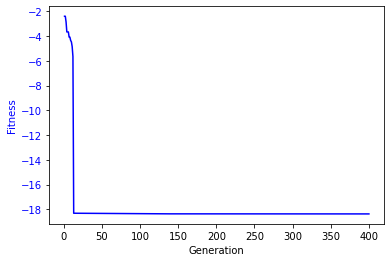

In [5]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

d = 30

def score_bic(individual):
    tup_idv = tuple(individual)
    if tup_idv in d_rew:
        reward = d_rew[tup_idv]
        return (reward,)

    graph = np.reshape(np.int32(individual), (d,d))
    reward = calc_reward(graph)
    d_rew[tup_idv] = reward
    return (reward,)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = d*d)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", score_bic)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("mean", np.mean)
stats.register("min", np.min) 

logbook = tools.Logbook()

if __name__ == "__main__":
    pop = toolbox.population(n=300)
  
    ngen, cxpb, mutpb = 400, 0.5, 0.2
    iter_num = 100

    print("Start of evolution")

  ## Code for correcting individual ##

    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

  # print("Evaluated %i individuals" % len(pop))

    for g in range(ngen):

        if((g+1)%iter_num == 0):
            print("Generation %i :  " % (g+1),)

        offspring = toolbox.select(pop, k=len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values
    
        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalids = [ind for ind in offspring if not ind.fitness.valid]

        ## Code for correcting individual ##

        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit

        # print ("Evaluated %i individuals" % len(invalids))

        pop[:] = offspring                     

        record = stats.compile(pop)
        logbook.record(gen=g+1, nevals=len(invalids), **record)

        if((g+1)%iter_num == 0):
            print(record)
      
    print("-- End of (successful) evolution --")
    print(tools.selBest(pop, k=1))
  # print(logbook)

    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    plt.show()

# Model 2


*   BIC + acyclicity constraints
*   Individual in form of flattened array
*   Random population initialization (or some DAG initialization)

(can try both lambdas changing and fixed)

Here, the GA is not able to explore well. Possible problem is that i-> and j->i both being there is an incentive to the scoring function
Possible alternatives:
- Try DAG initialization
- Change individual type to one triange of the matrix with options (i->j, j->i, no edge)
- solve the i->j and j-> conflict by randomly canceling one of them out



In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

inputdata = np.load('data.npy')
inputdata = StandardScaler().fit_transform(inputdata)
true_graph = np.load('DAG.npy').T
true_graph = np.int32(np.abs(true_graph) > 0.01)

d_rew = {}
d_RSS = {}

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def BIC_input_graph(X, g):
    """cal BIC score for given graph"""

    RSS_ls = []

    n, d = X.shape 

    reg = LinearRegression()

    for i in range(d):
        y_ = X[:, [i]]
        inds_x = list(np.abs(g[:, i])>0.1)

        if np.sum(inds_x) < 0.1: 
            y_pred = np.mean(y_)
        else:
            X_ = X[:, inds_x]
            reg.fit(X_, y_)
            y_pred = reg.predict(X_)
        RSSi = np.sum(np.square(y_ - y_pred))

        RSS_ls.append(RSSi)

    return np.log(np.sum(RSS_ls)/n+1e-8) 
    
    
def BIC_lambdas(X, gtrue):
    """
    :param X: dataset
    :param gtrue: input true graph
    :return: score lower bound, score upper bound, true score (only for monitoring)
    """
        
    n, d = X.shape

    bic_penalty = np.log(n) / (n*d)

    
    # default gl for BIC score: complete graph (except digonals)
    # gl : input graph to get score lower bound
    g_ones= np.ones((d,d))
    for i in range(d):
        g_ones[i, i] = 0
    gl = g_ones

    # default gu for BIC score: empty graph
    # gu : input graph to get score upper bound
    gu = np.zeros((d, d))

    sl = BIC_input_graph(X, gl)
    su = BIC_input_graph(X, gu) 

    # print(BIC_input_graph(X, gtrue))
    # print(gtrue)
    # print(bic_penalty)
    strue = BIC_input_graph(X, gtrue) + np.sum(gtrue) * bic_penalty
    print(sl, su, strue)
    return sl, su, strue

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.linalg import expm as matrix_exponential

def score_transform(s, sl, su, lambda1_upper):
  return (s-sl)/(su-sl)*lambda1_upper

def penalized_score(score_cyc, lambda1, lambda2):
  score, cyc = score_cyc
  return score + lambda1*np.float(cyc>1e-5) + lambda2*cyc

def calculate_yerr(X_train, y_train):
  ones = np.ones((inputdata.shape[0], 1), dtype=np.float32)
  X = np.hstack((X_train, ones))
  XtX = X.T.dot(X)
  Xty = X.T.dot(y_train)
  theta = np.linalg.solve(XtX, Xty)
  y_err = X.dot(theta) - y_train
  return y_err

def calc_reward(graph_batch, sl, su, lambda1_upper, lambda1, lambda2):
  datasize, d = inputdata.shape

  bic_penalty = np.log(datasize)/datasize

  RSS_ls = []

  for i in range(d):
    col = graph_batch[:, i]
    col_enc = np.append(col, i)
    tup_col = tuple(col_enc)

    #extracting RSS from memory
    if tup_col in d_RSS:
      RSS_ls.append(d_RSS[tup_col])
      continue

    if np.sum(col) < 0.1:
      y_err = inputdata[:, i]
      y_err = y_err - np.mean(y_err)

    else:
      cols_TrueFalse = col > 0.5
      X_train = inputdata[:, cols_TrueFalse]
      y_train = inputdata[:, i]
      y_err = calculate_yerr(X_train, y_train)

    RSSi = np.sum(np.square(y_err))

    RSS_ls.append(RSSi)
    d_RSS[tup_col] = RSSi

  BIC = np.log(np.sum(RSS_ls)/datasize+1e-8) \
                  + np.sum(graph_batch)*bic_penalty/d

  score = score_transform(BIC, sl, su, lambda1_upper)
  cycness = np.trace(matrix_exponential(np.array(graph_batch)))- d
  reward = score + lambda1*np.float(cycness>1e-5) + lambda2*cycness

  return reward, score, cycness

In [ ]:
import random
import numpy as np
from deap import algorithms, base, creator, tools
import multiprocessing

def isDAG (individual):
  tup_idv = tuple(individual)
  _, cyc = d_rew[tup_idv]
  return (cyc < 1e-5)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

d = 12

def score_bic(individual):
  tup_idv = tuple(individual)
  if tup_idv in d_rew:
    score_cyc = d_rew[tup_idv]
    return (penalized_score(score_cyc, lambda1, lambda2),)

  graph = np.reshape(np.int32(individual), (d,d))
  reward, score, cyc = calc_reward(graph, sl, su, lambda1_upper, lambda1, lambda2)
  d_rew[tup_idv] = (score, cyc)
  return (reward,)

toolbox = base.Toolbox()
# pool = multiprocessing.Pool()
# toolbox.register("map", pool.map)
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = d*d)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", score_bic)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=4)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("mean", np.mean)
stats.register("min", np.min) 

logbook = tools.Logbook()

if __name__ == "__main__":

  #Lambda initializations
  sl, su, strue = BIC_lambdas(inputdata, true_graph)
  lambda1 = 0
  lambda1_upper = 5
  lambda1_update_add = 1
  lambda2 = 1/(10**(np.round(d/3)))
  lambda2_upper = 0.01
  lambda2_update_mul = 10

  pop = toolbox.population(n=300)

  #masking [i,i]
  for ind in pop:
      for i in range(0, d*d, d+1):
        ind[i] = 0

  ngen, cxpb, mutpb = 20000, 0.5, 0.2
  iter_num = 1000

  print("Start of evolution")

  fitnesses = toolbox.map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

  # print("Evaluated %i individuals" % len(pop))

  for g in range(ngen):

    if ((g+1)%iter_num == 0):
      print("Generation %i :  " % (g+1),)
      print(lambda1, lambda2)
    
    #Updating lambda after every iter_num iterations
    if ((g+1)%iter_num == 0 and g != 0):
      cur_best = tools.selBest(pop, k=1)[0]
      if (isDAG(cur_best)):
        lambda1_upper = score_min
      lambda1 = min(lambda1+lambda1_update_add, lambda1_upper)
      lambda2 = min(lambda2*lambda2_update_mul, lambda2_upper)

    offspring = toolbox.select(pop, k=len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < cxpb:
        toolbox.mate(child1, child2)
        del child1.fitness.values, child2.fitness.values
    
    for mutant in offspring:
      if random.random() < mutpb:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    

    invalids = [ind for ind in offspring if not ind.fitness.valid]  #all the newly made

    #masking [i,i]
    for ind in offspring:
      for i in range(0, d*d, d+1):
        ind[i] = 0

    fitnesses = toolbox.map(toolbox.evaluate, offspring)
    for ind, fit in zip(offspring, fitnesses):
      ind.fitness.values = fit
 
    # print ("Evaluated %i individuals" % len(invalids))

    pop[:] = offspring                     
    
    record = stats.compile(pop)
    logbook.record(gen=g+1, nevals=len(invalids), **record)

    if ((g+1)%iter_num == 0):
      print(record)
      
  print("-- End of (successful) evolution --")
  print(tools.selBest(pop, k=1))
  # print(logbook)

  gen = logbook.select("gen")
  fit_mins = logbook.select("min")
  import matplotlib.pyplot as plt
  fig, ax1 = plt.subplots()
  line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
  ax1.set_xlabel("Generation")
  ax1.set_ylabel("Fitness", color="b")
  for tl in ax1.get_yticklabels():
      tl.set_color("b")
  plt.show()

# Model 3


*   BIC 
*   Function for cycle removal
*   Individual in form of flattened array
*   Random population initialization (or some DAG initialization)





In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

inputdata = np.load('data.npy')
inputdata = StandardScaler().fit_transform(inputdata)
true_graph = np.load('DAG.npy').T
true_graph = np.int32(np.abs(true_graph) > 0.01)

d_rew = {}
d_RSS = {}

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def calculate_yerr(X_train, y_train):
  ones = np.ones((inputdata.shape[0], 1), dtype=np.float32)
  X = np.hstack((X_train, ones))
  XtX = X.T.dot(X)
  Xty = X.T.dot(y_train)
  theta = np.linalg.solve(XtX, Xty)
  y_err = X.dot(theta) - y_train
  return y_err

def calc_reward(graph_batch):
  datasize, d = inputdata.shape

  bic_penalty = np.log(datasize)/datasize

  RSS_ls = []

  for i in range(d):
    col = graph_batch[:, i]
    col_enc = np.append(col, i)
    tup_col = tuple(col_enc)

    #extracting RSS from memory
    if tup_col in d_RSS:
      RSS_ls.append(d_RSS[tup_col])
      continue

    if np.sum(col) < 0.1:
      y_err = inputdata[:, i]
      y_err = y_err - np.mean(y_err)

    else:
      cols_TrueFalse = col > 0.5
      X_train = inputdata[:, cols_TrueFalse]
      y_train = inputdata[:, i]
      y_err = calculate_yerr(X_train, y_train)

    RSSi = np.sum(np.square(y_err))

    RSS_ls.append(RSSi)
    d_RSS[tup_col] = RSSi

  BIC = np.log(np.sum(RSS_ls)/datasize+1e-8) \
                  + np.sum(graph_batch)*bic_penalty/d

  return BIC

In [ ]:
def remove_edge(s, ind, ind_orig, visited, recStack, d):
    visited[s] = True
    recStack[s] = True
    
    l = list(range(d))
    random.shuffle(l)
    for neighbour in l:
        if ind[s][neighbour] != 0:
            if visited[neighbour] == False:
                remove_edge(neighbour, ind, ind_orig, visited, recStack, d)
            elif recStack[neighbour] == True:
                ind[s][neighbour] = 0
                ind_orig[s*d + neighbour] = 0
    
    recStack[s] = False


def remove_cycle(ind_orig):
    ind = np.array(ind_orig)
    d = int(ind.shape[0] ** 0.5)
    ind = ind.reshape(d, d)

    visited = [False] * d
    recStack = [False] * d 
    
    l = list(range(d))
    random.shuffle(l)
    for node in l:
        if visited[node] == False:
            remove_edge(node, ind, ind_orig, visited, recStack, d)
  

In [ ]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

d = 12

def score_bic(individual):
  tup_idv = tuple(individual)
  if tup_idv in d_rew:
    reward = d_rew[tup_idv]
    return (reward,)

  graph = np.reshape(np.int32(individual), (d,d))
  reward = calc_reward(graph)
  d_rew[tup_idv] = reward
  return (reward,)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = d*d)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", score_bic)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("mean", np.mean)
stats.register("min", np.min) 

logbook = tools.Logbook()

if __name__ == "__main__":
  pop = toolbox.population(n=300)

  ngen, cxpb, mutpb = 200, 0.5, 0.2
  iter_num = 100

  print("Start of evolution")

  #masking [i,i] # removal of self loops
  for ind in pop:
      for i in range(0, d*d, d+1):
        ind[i] = 0

  for ind in pop:
    remove_cycle(ind) ## input individual

  fitnesses = toolbox.map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

  # print("Evaluated %i individuals" % len(pop))

  for g in range(ngen):

    if((g+1)%iter_num == 0):
      print("Generation %i :  " % (g+1),)

    offspring = toolbox.select(pop, k=len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < cxpb:
        toolbox.mate(child1, child2)
        del child1.fitness.values, child2.fitness.values
    
    for mutant in offspring:
      if random.random() < mutpb:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalids = [ind for ind in offspring if not ind.fitness.valid]

    #masking [i,i]
    for ind in invalids:
      for i in range(0, d*d, d+1):
        ind[i] = 0

    for ind in invalids:
      remove_cycle(ind) ## input individual

    fitnesses = toolbox.map(toolbox.evaluate, invalids)
    for ind, fit in zip(invalids, fitnesses):
      ind.fitness.values = fit
 
    # print ("Evaluated %i individuals" % len(invalids))

    pop[:] = offspring                     
    
    record = stats.compile(pop)
    logbook.record(gen=g+1, nevals=len(invalids), **record)

    if((g+1)%iter_num == 0):
      print(record)
      
  print("-- End of (successful) evolution --")
  print(tools.selBest(pop, k=1))
  # print(logbook)

  gen = logbook.select("gen")
  fit_mins = logbook.select("min")
  import matplotlib.pyplot as plt
  fig, ax1 = plt.subplots()
  line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
  ax1.set_xlabel("Generation")
  ax1.set_ylabel("Fitness", color="b")
  for tl in ax1.get_yticklabels():
      tl.set_color("b")
  plt.show()

# Model 4


*   BIC 
*   Individual in form of edges in skeletan




*   BIC not working well, graphs that are not true_dag are getting lower values



In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

inputdata = np.load('data.npy')
inputdata = StandardScaler().fit_transform(inputdata)
true_graph = np.load('DAG.npy').T
true_graph = np.int32(np.abs(true_graph) > 0.01)

def mat_dic(mat):
    dic = {}
    
    n = mat.shape[0]
    index = 0
    
    for i in range(n):
      for j in range(i + 1, n):
          if mat[i][j] == 1 or mat[j][i] == 1:
              dic[(i, j)] = index
              index += 1
                    
    return dic

dic = mat_dic(true_graph)

d_rew = {}
d_RSS = {}

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def calculate_yerr(X_train, y_train):
  ones = np.ones((inputdata.shape[0], 1), dtype=np.float32)
  X = np.hstack((X_train, ones))
  XtX = X.T.dot(X)
  Xty = X.T.dot(y_train)
  theta = np.linalg.solve(XtX, Xty)
  y_err = X.dot(theta) - y_train
  return y_err

def calc_reward(graph_batch):
  datasize, d = inputdata.shape

  bic_penalty = np.log(datasize)/datasize

  RSS_ls = []

  for i in range(d):
    col = graph_batch[:, i]
    col_enc = np.append(col, i)
    tup_col = tuple(col_enc)

    #extracting RSS from memory
    if tup_col in d_RSS:
      RSS_ls.append(d_RSS[tup_col])
      continue

    if np.sum(col) < 0.1:
      y_err = inputdata[:, i]
      y_err = y_err - np.mean(y_err)

    else:
      cols_TrueFalse = col > 0.5
      X_train = inputdata[:, cols_TrueFalse]
      y_train = inputdata[:, i]
      y_err = calculate_yerr(X_train, y_train)

    RSSi = np.sum(np.square(y_err))

    RSS_ls.append(RSSi)
    d_RSS[tup_col] = RSSi

  BIC = np.log(np.sum(RSS_ls)/datasize+1e-8) \
                  + np.sum(graph_batch)*bic_penalty/d

  return BIC

In [ ]:
def idv_to_matrix(idv, dic, d):
  matrix = np.zeros((d,d))

  for pair in dic:
    i, j = pair
    idx = dic[pair]
    if idv[idx] == 0:
      matrix[i][j] = 1
    elif (idv[idx] == 1):
      matrix[j][i] = 1
  
  return matrix

def reverse_edge(s, ind, ind_orig, visited, recStack, dic, d):
    visited[s] = True
    recStack[s] = True
    
    l = list(range(d))
    random.shuffle(l)
    for neighbour in l:
      if ind[s][neighbour] != 0:
            if visited[neighbour] == False:
                reverse_edge(neighbour, ind, ind_orig, visited, recStack, dic, d)
            elif recStack[neighbour] == True:
                ind[s][neighbour] = 0
                ind[neighbour][s] = 1
                idx = dic[(min(s,neighbour), max(s, neighbour))]
                ind_orig[idx] = ind_orig[idx] ^ 1
    
    recStack[s] = False


def remove_cycle2(ind_orig, dic, d):
    ind = idv_to_matrix(ind_orig, dic, d)

    visited = [False] * d
    recStack = [False] * d 
    
    l = list(range(d))
    random.shuffle(l)
    for node in l:
        if visited[node] == False:
            reverse_edge(node, ind, ind_orig, visited, recStack, dic, d)


In [ ]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

d = inputdata.shape[1]

def score_bic(individual):
  tup_idv = tuple(individual)
  if tup_idv in d_rew:
    reward = d_rew[tup_idv]
    return (reward,)

  graph = idv_to_matrix(individual, dic, d)
  reward = calc_reward(graph)
  d_rew[tup_idv] = reward
  return (reward,)

def giveNum (p0, p1, p2):     #p0, p1, p2 are probability of 0, 1, 2 respectively
  choice = random.random()
  if choice <= p0:
    return 0      # edge from i->j
  elif choice <= p0+p1:
    return 1      # edge from j->i
  else:
    return 2      # delete edge

toolbox = base.Toolbox()
toolbox.register("attr_num", giveNum, 0.4, 0.4, 0.2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_num, n = len(dic))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", score_bic)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
# toolbox.register("mutate", tools.mutUniformInt, 0, 2, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("mean", np.mean)
stats.register("min", np.min) 

logbook = tools.Logbook()

if __name__ == "__main__":
  pop = toolbox.population(n=300)

  ngen, cxpb, mutpb = 200, 0.5, 0.2
  iter_num = 100

  print("Start of evolution")

  for ind in pop:
    remove_cycle2(ind, dic, d) ## input individual

  fitnesses = toolbox.map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

  # print("Evaluated %i individuals" % len(pop))

  for g in range(ngen):

    if((g+1)%iter_num == 0):
      print("Generation %i :  " % (g+1),)

    offspring = toolbox.select(pop, k=len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < cxpb:
        toolbox.mate(child1, child2)
        del child1.fitness.values, child2.fitness.values
    
    for mutant in offspring:
      if random.random() < mutpb:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalids = [ind for ind in offspring if not ind.fitness.valid]

    for ind in invalids:
      remove_cycle2(ind, dic, d) ## input individual

    fitnesses = toolbox.map(toolbox.evaluate, invalids)
    for ind, fit in zip(invalids, fitnesses):
      ind.fitness.values = fit
 
    # print ("Evaluated %i individuals" % len(invalids))

    pop[:] = offspring                     
    
    record = stats.compile(pop)
    logbook.record(gen=g+1, nevals=len(invalids), **record)

    if((g+1)%iter_num == 0):
      print(record)
      
  print("-- End of (successful) evolution --")
  print(tools.selBest(pop, k=1))
  # print(logbook)

  gen = logbook.select("gen")
  fit_mins = logbook.select("min")
  import matplotlib.pyplot as plt
  fig, ax1 = plt.subplots()
  line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
  ax1.set_xlabel("Generation")
  ax1.set_ylabel("Fitness", color="b")
  for tl in ax1.get_yticklabels():
      tl.set_color("b")
  plt.show()

In [ ]:
a = tools.selBest(pop, k=1)
gr = idv_to_matrix(a[0], dic, d)
gr

In [ ]:
 from scipy.linalg import expm as matrix_exponential
 cycness = np.trace(matrix_exponential(np.array(gr)))- d
 cycness

# Model 5



*   Skeleton
*   BGe score



In [ ]:
import numpy as np
data = np.loadtxt('generated_graph_scorebased_noheader.csv', delimiter=',')
print(data.shape) 

In [ ]:
graph = np.loadtxt('generated_graph_scorebased_target.csv', delimiter=',', skiprows=1)
print(graph.shape) 
print(graph)

In [ ]:
import rpy2.robjects.packages as rpackages

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

utils.install_packages("BiocManager")
BiocManager = rpackages.importr("BiocManager")

BiocManager.install('graph')
BiocManager.install('Rgraphviz')
BiocManager.install('RBGL')

utils.install_packages('ggm')
utils.install_packages('pcalg')
utils.install_packages('BiDAG')
utils.install_packages('SID')

In [ ]:
import numpy as np
import multiprocessing
from sklearn.preprocessing import StandardScaler
from rpy2.robjects import numpy2ri

inputdata = np.load('data.npy')
inputdata = StandardScaler().fit_transform(inputdata)
dataR = numpy2ri.py2rpy(inputdata)
true_graph = np.load('DAG.npy').T
true_graph = np.int32(np.abs(true_graph) > 0.01)

def mat_dic(mat):
    dic = {}
    
    n = mat.shape[0]
    index = 0
    
    for i in range(n):
        for j in range(i + 1, n):
              if mat[i][j] == 1 or mat[j][i] == 1:
                dic[(i, j)] = index
                index += 1
                    
    return dic

dic = mat_dic(true_graph)


d_rew = {}

In [ ]:
from rpy2.robjects import numpy2ri

def calc_reward(dag):
    BiDAG = rpackages.importr('BiDAG')
    nodes = dag.shape[1]
    dagR = numpy2ri.py2rpy(dag)

    scorepar = BiDAG.scoreparameters(nodes, "bge", dataR)
    score = BiDAG.DAGscore(scorepar, dagR)

    return np.array(score)[0]


def calc_sid(pred, true): # input adjacency matrices
    trueR = numpy2ri.py2rpy(true)
    predR = numpy2ri.py2rpy(pred)
    sid = rpackages.importr('SID')
    return np.array(sid.structIntervDist(trueR, predR))[0]


def calc_shd(pred, true): # input adjacency matrices
    trueR = numpy2ri.py2rpy(true)
    predR = numpy2ri.py2rpy(pred)
    sid = rpackages.importr('SID')
    return np.array(sid.hammingDist(trueR, predR))[0]

def calc_tpr(pred, true):
    tp = np.sum(true & pred)
    fn = np.sum(true & (~ pred))
    fp = np.sum(pred & (~ true))
    return tp/(tp+fn)

def calc_fdr(pred, true):
    tp = np.sum(true & pred)
    fn = np.sum(true & (~ pred))
    fp = np.sum(pred & (~ true))
    return fp/(tp+fp)


In [ ]:
def idv_to_matrix(idv, dic, d):
    matrix = np.zeros((d,d))

    for pair in dic:
        i, j = pair
        idx = dic[pair]
        if idv[idx] == 0:
            matrix[i][j] = 1
        elif (idv[idx] == 1):
            matrix[j][i] = 1
  
    return matrix

def reverse_edge(s, ind, ind_orig, visited, recStack, dic, d):
    visited[s] = True
    recStack[s] = True
    
    l = list(range(d))
    random.shuffle(l)
    for neighbour in l:
        if ind[s][neighbour] != 0:
            if visited[neighbour] == False:
                reverse_edge(neighbour, ind, ind_orig, visited, recStack, dic, d)
            elif recStack[neighbour] == True:
                ind[s][neighbour] = 0
                ind[neighbour][s] = 1
                idx = dic[(min(s,neighbour), max(s, neighbour))]
                ind_orig[idx] = ind_orig[idx] ^ 1
    
    recStack[s] = False


def remove_cycle2(ind_orig, dic, d):
    ind = idv_to_matrix(ind_orig, dic, d)

    visited = [False] * d
    recStack = [False] * d 
    
    l = list(range(d))
    random.shuffle(l)
    for node in l:
        if visited[node] == False:
            reverse_edge(node, ind, ind_orig, visited, recStack, dic, d)


In [ ]:
import random
from tqdm import tqdm
import numpy as np
import multiprocessing
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

d = inputdata.shape[1]

def score_BGe(individual):
    tup_idv = tuple(individual)
      if tup_idv in d_rew:
        reward = d_rew[tup_idv]
    return (reward,)

    graph = idv_to_matrix(individual, dic, d)
    reward = calc_reward(graph)
    d_rew[tup_idv] = reward
    return (reward,)

def giveNum (p0, p1, p2):     #p0, p1, p2 are probability of 0, 1, 2 respectively
    choice = random.random()
    if choice <= p0:
        return 0      # edge from i->j
    elif choice <= p0+p1:
        return 1      # edge from j->i
    else:
        return 2      # delete edge

toolbox = base.Toolbox()

pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

toolbox.register("attr_num", giveNum, 0.5, 0.5, 0.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_num, n = len(dic))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", score_BGe)
# toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mate", tools.cxUniform, indpb = 0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=4)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("mean", np.mean)
stats.register("min", np.min) 

logbook = tools.Logbook()

if __name__ == "__main__":
    pop = toolbox.population(n=500)

    ngen, cxpb, mutpb = 200, 0.5, 0.2
    iter_num = 50

    print("Start of evolution")

    for ind in pop:
        remove_cycle2(ind, dic, d) ## input individual

    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

  # print("Evaluated %i individuals" % len(pop))

  for g in tqdm(range(1, ngen+1)):

    offspring = toolbox.select(pop, k=len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values, child2.fitness.values
    
    for mutant in offspring:
          if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalids = [ind for ind in offspring if not ind.fitness.valid]

    for ind in invalids:
        remove_cycle2(ind, dic, d) ## input individual

    fitnesses = toolbox.map(toolbox.evaluate, invalids)
    for ind, fit in zip(invalids, fitnesses):
         ind.fitness.values = fit
 
    # print ("Evaluated %i individuals" % len(invalids))

    pop[:] = offspring                     
    
    record = stats.compile(pop)
    logbook.record(gen=g+1, nevals=len(invalids), **record)

    if((g)%iter_num == 0):
        print()
        print("Generation %i :  " % (g),)
        print(record)
      
    print("-- End of (successful) evolution --")
    print(tools.selBest(pop, k=1))
  # print(logbook)

    gen = logbook.select("gen")
    fit_maxs = logbook.select("max")
    
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_maxs, "b-", label="Maximum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    plt.show()

In [ ]:
a = tools.selBest(pop, k=1)
graph = idv_to_matrix(a[0], dic, d)
graph = np.int32(graph)
graph

In [ ]:
calc_reward(true_graph)

In [ ]:
tp = np.sum(true_graph & graph)
rev = np.sum(true_graph & graph.T)
mis = np.sum(true_graph & (~ graph))-rev
ext = np.sum(graph & (~ true_graph))-rev

print(tp, rev, mis, ext)

Other things to be tried after decinding upon some skeletal finding method